In [9]:
import numpy as np
from utils import *
from scipy.stats import binom
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy.integrate import quad

## Utility Functions

In [10]:
def find_max(function, bound_low, bound_high, grid=100000,):
    """
    Return the maximum value of a function
    """
    if (not grid >= 0):
        raise ValueError("Grid must be a a positive intiger")
    # Generate grid of x values
    x = np.linspace(bound_low, bound_high, num=grid, endpoint=True,)
    y = function(x)
    return y.max()

def find_significance(pdf, interval_limits):
    """
    Compute the p_value and significance value of a interval
    """

    # Compute integrals
    full_integral = pdf.integrate( (pdf.boundMin, pdf.boundMax) )
    interval_integral = pdf.integrate(interval_limits)

    # Compute p value of probability
    p_value = interval_integral/full_integral

    n_sigma = compute_z_score(p_value)

    return (p_value, n_sigma) 

def compute_z_score(p_value):
    """
    Compute significance value from p_value
    """

    # Compute Z score
    n_sigma = np.sqrt(2) * erfinv(1 - p_value)

    return n_sigma

## Classes

### Parent Classes

In [ ]:
class ProbabilityDensityFunction(object):
    """
    Parent class containing common methods and members to be used by all pdf classes
    """

    def __init__(self, bounds):

        if (not isinstance(bounds, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (boundMin, boundMax)")
        if (not len(bounds) == 2):
            raise ValueError("Variable bound must have form (boundMin, boundMax)")
        if (not bounds[0] < bounds[1]):
            raise ValueError("First element in tuple must be smaller than second")
        
        # Initialise class variables
        self.boundMin, self.boundMax = bounds
        # Initialise list to hold randomly generated mass values
        self.mass = []

    def integrate(self, limits):
        """
        Evaluate the integral of the pdf within the specified bounds
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not isinstance(limits, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (limitMin, limitMax)")
        if (not len(limits) == 2):
            raise ValueError("Variable bound must have form (limitMin, limitMax)")
        if (not limits[0] < limits[1]):
            raise ValueError("First element in tuple must be smaller than second")
        if (not limits[0] >= self.boundMin):
            raise ValueError("Lower integral limit must be larger than lower bound of pdf")
        if (not limits[1] <= self.boundMax):
            raise ValueError("Higher integral limit must be smaller than upper bound of pdf")
    
        limitLow, limitHigh = limits
        integralResult, IntegralError = quad(self._evaluate, limitLow, limitHigh) 
        return integralResult
    
    def getMass(self,):
        """
        Return numpy array containing all generated values
        """

        return np.array(self.mass)

### Child Classes

In [ ]:

class Gaussian(ProbabilityDensityFunction):
    """
    Class that will generate a random value according to a gaussian distribution using numpy.random.normal
    """

    def __init__(self, mean, sigma, bounds):

        # Initialise parent class
        super().__init__(bounds)
        
        # Initialise class variables
        self.mean = mean
        self.sigma = sigma
        # Find maximum value of the distribution within the bounds
        self.maxValue = find_max(self._evaluate, self.boundMin, self.boundMax)

    def _evaluate(self, x,):
        """
        Evaluate the gaussian function of the distribution
        ##### NOTE: Returns un-normalised values between the bounds #####
        """

        return 1/(self.sigma * np.sqrt(2.0*np.pi)) * np.exp( -(x-self.mean)**2 / (2.0 * self.sigma**2) )

    def next(self,):
        """
        Generate a single random variable according to the class' distribution using numpy.random.normal method
        Will return and append generated variable to mass list.
        """

        # Use .item() to append vsariable inside array and not array itself
        x = np.random.normal(self.mean, self.sigma, size=1).item()
        self.mass.append(x)
        return x

    def setParameters(self, mean=None, sigma=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not mean == None:                self.mean = mean 
        if not sigma == None:               self.sigma = sigma

## Excercises

Below are the 4 excersices for the checkpoint

### Excercise 1

In [11]:
CLAIMED_FAULTY_RATE = 0.05
ACTUAL_FAULTY_RATE = 0.15
SAMPLE_SIZE = 100
X_CUT = 9


x = np.arange(0, 100, 1,)
claimed_faulty_distribution = binom(SAMPLE_SIZE, CLAIMED_FAULTY_RATE)
actual_faulty_distribution = binom(SAMPLE_SIZE, ACTUAL_FAULTY_RATE)

# Compute Type-I error 
x_mask_type_1 = x <= X_CUT
type_1_error = claimed_faulty_distribution.pmf(x)[x_mask_type_1].sum()

# Compute Type 2 mask
# Not that the mask used is the inverse of the mask calculated above
x_mask_type_2 = x >= X_CUT
type_2_error = actual_faulty_distribution.pmf(x)[x_mask_type_2].sum()

print(f"The type I error is {type_1_error:.3f}")
print(f"The type II error is {type_2_error:.3f}")

The type I error is 0.972
The type II error is 0.973


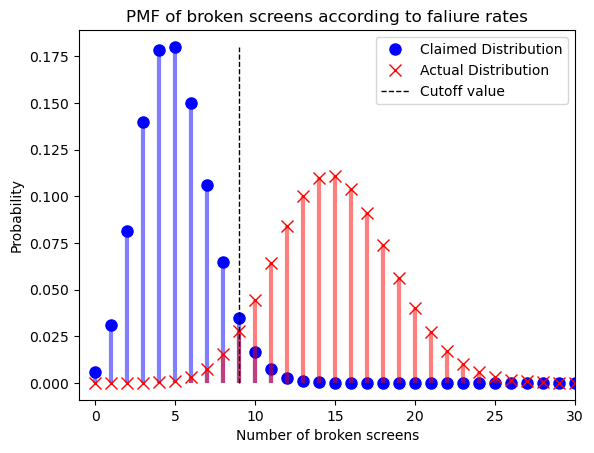

In [15]:
fig, ax = plt.subplots(1, 1)

# Plot claimed distribution
ax.plot(x, claimed_faulty_distribution.pmf(x), 'bo', ms=8, label='Claimed Distribution')
ax.vlines(x, 0, claimed_faulty_distribution.pmf(x,), colors='b', lw=3, alpha=0.5)

# Plot actual distribution
ax.plot(x, actual_faulty_distribution.pmf(x), 'rx', ms=8, label='Actual Distribution')
ax.vlines(x, 0, actual_faulty_distribution.pmf(x,), colors='r', lw=3, alpha=0.5)
ax.vlines(X_CUT, 0, claimed_faulty_distribution.pmf(x).max(), colors="black", linestyles="--", label="Cutoff value", lw=1)

plt.legend()
plt.xlabel("Number of broken screens")
plt.ylabel("Probability")
plt.title("PMF of broken screens according to faliure rates")
plt.xlim(-1, 30)
plt.show()

### Excercise 2